In [1]:
from __future__ import (division, print_function)

In [2]:
%autoreload 2
%matplotlib inline

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [136]:
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import seaborn as sns
sns.set_style('white')

In [50]:
import statsmodels as sm

In [47]:
from seaborn.distributions \
    import _statsmodels_bivariate_kde as bivariate_KDE

In [7]:
import sys
sys.path.append("../")
import extract_catalog as ec
import plot_gal_prop as plotg

In [8]:
partDMfile = "../../data/Illustris-1_" + \
    "00135_APillepich_KarenNG_ParticleData_Group_PartType1.h5"

data_f = h5py.File("../../data/Illustris-1_fof_subhalo" +
                   "_myCompleteHaloCatalog_00135.hdf5")

In [9]:
partDM = h5py.File(partDMfile)

In [170]:
no = 7
size=1e3

In [171]:
part_halos = h5py.File("../../data/DM_particles_clst_loc.h5")
haloEndIx = part_halos["loc"][...]

In [172]:
haloEndIx[5] - haloEndIx[4]

30285624

In [173]:
coords.shape

(30285624, 2)

In [174]:
haloEndIx[4]

242206403

In [175]:
clst5 = \
    partDM["PartType1_Coordinates"][:2, 
                                    haloEndIx[no-1]:haloEndIx[no]]

In [176]:
wrapped_coords = np.array([ec.wrap_and_center_coord(clst5[i, :]) 
                           for i in range(2)]).transpose()
min_coord1 = np.min(wrapped_coords[:, 0])
min_coord2 = np.min(wrapped_coords[:, 1])
coords = wrapped_coords - np.array([min_coord1, min_coord2])


In [177]:
def get_dens_and_grid(x, y, bw='normal_reference', 
                      gridsize=100, cut=4, 
                      clip=[-np.inf, np.inf], n_jobs=10):
    from seaborn.distributions \
    import _kde_support 
    import statsmodels.nonparametric.kernel_density as KDE
    KDEMultivariate = KDE.KDEMultivariate
    
    kde = KDEMultivariate(np.array([x, y]),
                          var_type='cc', bw=bw)
    kde.n_jobs = n_jobs
    
    x_support = _kde_support(x, kde.bw[0], gridsize, cut, clip)
    y_support = _kde_support(y, kde.bw[1], gridsize, cut, clip)
    xx, yy = np.meshgrid(x_support, y_support)
      
    z = kde.pdf([xx.ravel(), yy.ravel()]).reshape(xx.shape)
    return xx, yy, z
    

(0, 3000)

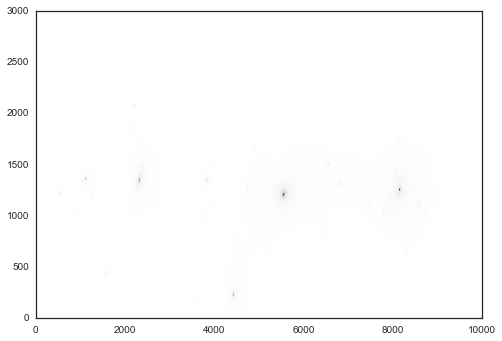

In [188]:
counts, xedges, yedges, image = \
    plt.hist2d(coords[:, 0], coords[:, 1], bins=1e3,
               range=[[0, 10000], [0, 3000]])
plt.ylim(0, 3000)

In [189]:
xbin_width = xedges[1] - xedges[0] 

In [190]:
ybin_width = yedges[1] - yedges[0]

In [191]:
counts.shape

(1000, 1000)

In [192]:
ybin_width

3.0

In [193]:
xbin_width

10.0

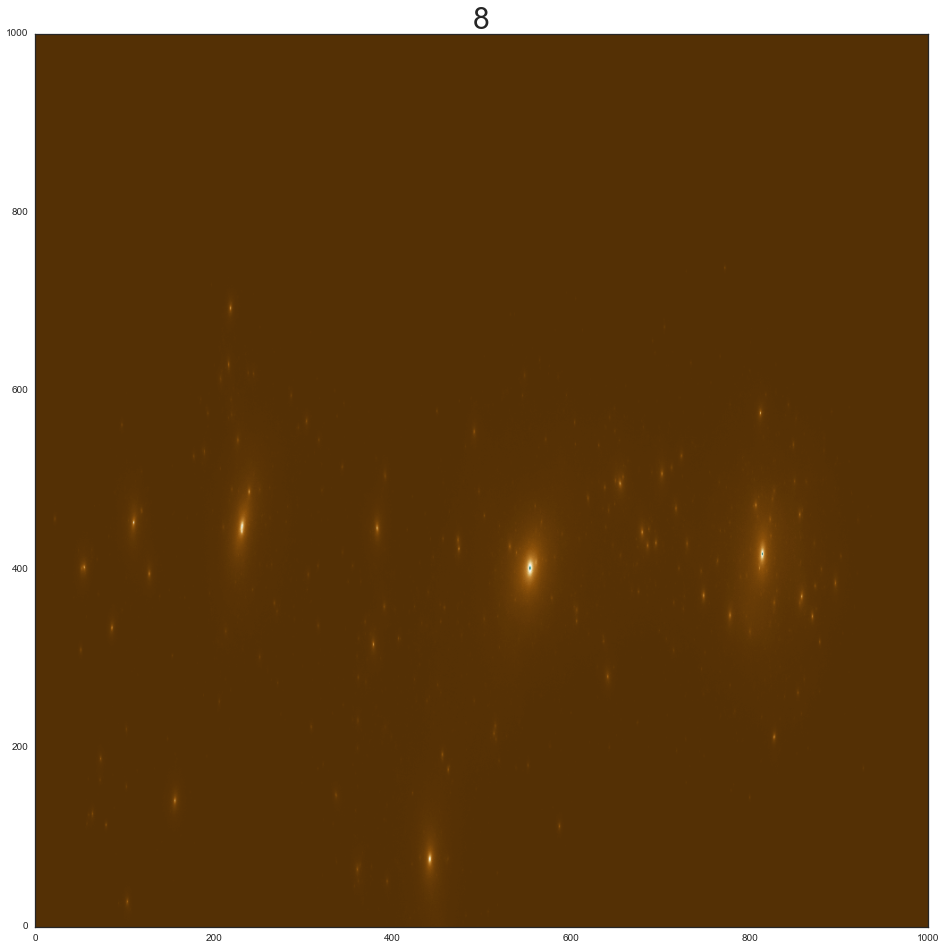

In [194]:
plt.figure(figsize=(16, 16))
plt.imshow(counts.transpose(), cmap=plt.cm.BrBG,
           origin='lower')
plt.title(partDM['PartType1_HaloID'][haloEndIx[no-1]],
          fontsize=30)

```
get_dens_and_grid(wrapped_coords[:, 0], wrapped_coords[:, 1])
```